## Analysis for Cortical Cell Images

A comprehensive workflow for enhancing microscopy images of cortical cells and performing FFT analysis on them.

Developed by: 
Roberto dos Reis, PhD - Northwestern Univeristy/2025 

roberto.reis@northwestern.edu

and

Paloma Lee - Northwestern University/2025

palomalee2025@u.northwestern.edu


This notebook is part of the paper entitled:
(TBD)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from pathlib import Path

import ncempy.io as nio

from scipy.ndimage import median_filter
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar


## Load and Display the Original Image

First, let's load the image and examine it.

In [30]:
# file_path = 'selected_images/2024-07-11_3200_Wool_Devon/Devon_5E w UA -EtOH_20kX_0031.dm4' #linear
file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0032.dm4' #linear
 
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0013.dm4' #circular
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0021.dm4' #circular
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0022.dm4' #circular

# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0034.dm4' #hex
# file_path = 'selected_images/Devon_5E w UA -EtOH_20kX_0035.dm4' #hex


In [31]:
def load_dm4(file_path):
    dmData = nio.read(file_path)
    return dmData

im_data= load_dm4(file_path)

print(im_data['data'].shape) # the shape of the data
print(im_data['pixelSize']) # print the pixel size

img = im_data['data']
scale = im_data['pixelSize']

(3838, 3710)
[0.18341091, 0.18341091]


In [32]:
# # Replace with the path to your image for a png/tiff image
# image_path = 'images/B_nonmag.png'

# # Load the image
# try:
#     img = load_image(image_path)
#     display_image(img, 'Original Image')
# except FileNotFoundError:
#     print("Please update the image_path variable with the correct path to your image.")
#     # You can also use a sample image for testing
#     # from skimage import data
#     # img = data.camera()
#     # display_image(img, 'Sample Test Image')

## Step 1: Image Pre-processing

Let's apply several pre-processing steps to enhance the image quality before FFT analysis.

(-0.5, 369.5, 381.5, -0.5)

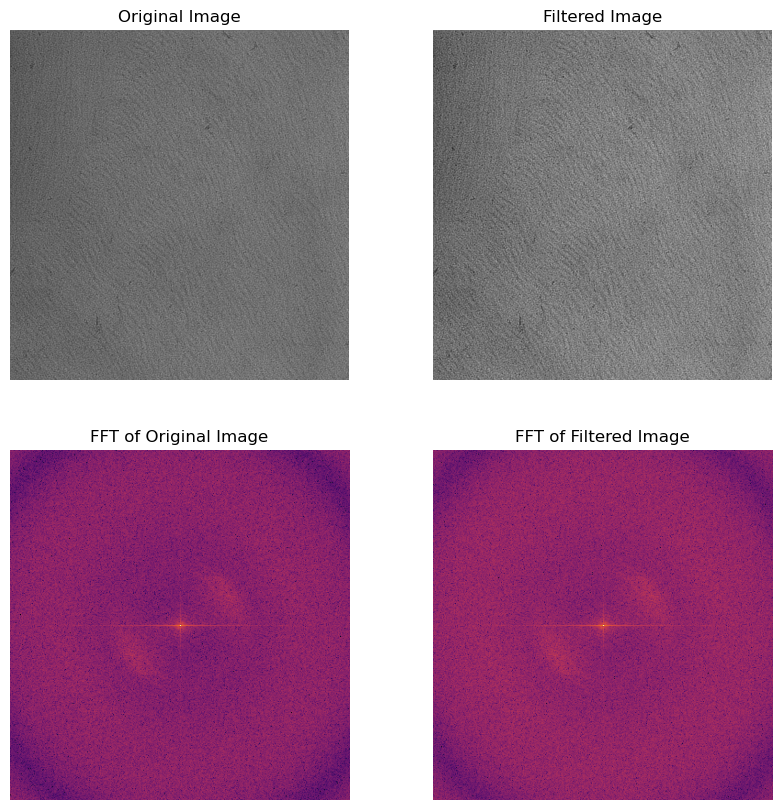

In [48]:
# Apply median filter
img_median = median_filter(img, size=5)

# Calculate FFT
fft_original = np.fft.fftshift(np.fft.fft2(img))
fft_filtered = np.fft.fftshift(np.fft.fft2(img_median))

# Calculate magnitude and apply log scaling
mag_orig = np.log1p(np.abs(fft_original))
mag_filt = np.log1p(np.abs(fft_filtered))

# Crop FFT to central portion (5%)
crop_factor = 0.05
h, w = mag_orig.shape
crop_h, crop_w = int(h * crop_factor), int(w * crop_factor)
center_h, center_w = h // 2, w // 2

mag_orig_crop = mag_orig[center_h - crop_h:center_h + crop_h, 
                         center_w - crop_w:center_w + crop_w]
mag_filt_crop = mag_filt[center_h - crop_h:center_h + crop_h, 
                         center_w - crop_w:center_w + crop_w]

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Display original image
axs[0, 0].imshow(img, cmap='gray')
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Display filtered image
axs[0, 1].imshow(img_median, cmap='gray')
axs[0, 1].set_title('Filtered Image')
axs[0, 1].axis('off')

# Display cropped FFT of original image
axs[1, 0].imshow(mag_orig_crop, cmap='inferno')
axs[1, 0].set_title('FFT of Original Image')
axs[1, 0].axis('off')

# Display cropped FFT of filtered image
axs[1, 1].imshow(mag_filt_crop, cmap='inferno')
axs[1, 1].set_title('FFT of Filtered Image')
axs[1, 1].axis('off')

